In [1]:
import os
import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
from pathlib import Path
from IPython.display import Image 
from collections import defaultdict
from intervaltree import Interval, IntervalTree
import pysam
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir=f"{proj_dir}/results"
os.chdir(results_dir)

In [3]:
Path(f"{results_dir}/stats_minus_introgressed_alleles").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/stats_minus_introgressed_alleles")

In [4]:
pca_df=pd.read_csv(f"{proj_dir}/results/pca/pca_df.csv", sep=",")

In [ ]:
# #read in rfmix
# df=pd.read_csv(f"{results_dir}/rfmix/rfmix_perc_bovis_genome.csv")
# df

In [ ]:
# filtered_callset=allel.read_vcf(f'{results_dir}/post_phase_filtering/chrs_unrelated.vcf')

In [ ]:
# gt      = allel.GenotypeArray(filtered_callset['calldata/GT'])
# chroms  = filtered_callset["variants/CHROM"]
# samples = filtered_callset["samples"]
# poss    = filtered_callset["variants/POS"]
# var_ids = filtered_callset["variants/ID"]

# uniq_chroms=np.unique(chroms)

In [ ]:
# #get kmeans_pop_idxs

# #now get an index for each sample/population
# samples = list(filtered_callset["samples"])

# #initiate list that will store the vcf idx for each sample in relation to the pca k group
# kmeans_pop_idxs = defaultdict(lambda: [])

# for sample in samples:
#     idx=samples.index(sample)
#     pop=pca_df.loc[pca_df["sample_name"] == sample, "kmeans_label"].values[0]
#     kmeans_pop_idxs[pop].append(idx)

In [ ]:
# nw_acs = gt.count_alleles(subpop=kmeans_pop_idxs["sh_nw"])
# se_acs = gt.count_alleles(subpop=kmeans_pop_idxs["sh_se"])
# sb_acs = gt.count_alleles(subpop=kmeans_pop_idxs["sb"])

# Mask out introgressed alleles identified in RFMix

In [6]:
#read in rfmix table
rf_df=pd.read_csv(f"{results_dir}/rfmix/rfmix_df.csv")
rf_df

,chrom,s_pos,e_pos,s_gpos,e_gpos,n_snps,Sb_NG_au_1.2.0,Sb_NG_au_1.2.1,Sb_NG_au_2.13.0,Sb_NG_au_2.13.1,...,ssp_niger_libore_166.0,ssp_niger_libore_166.1,ssp_niger_libore_167.0,ssp_niger_libore_167.1,ssp_niger_libore_168.0,ssp_niger_libore_168.1,ssp_niger_libore_169.0,ssp_niger_libore_169.1,ssp_zambia_kafue_71.0,ssp_zambia_kafue_71.1
0,NC_067196.1,124225,212192,0.43,0.74,1302,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,NC_067196.1,212192,289797,0.74,1.01,860,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,NC_067196.1,289797,302958,1.01,1.06,645,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,NC_067196.1,302958,623463,1.06,2.17,2980,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,NC_067196.1,623463,625997,2.17,2.18,25,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,162.92,162.93,365,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39473,NC_067199.1,46761155,46761224,162.93,162.93,15,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39474,NC_067199.1,46761224,46762583,162.93,162.94,115,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
39475,NC_067199.1,46762583,46763230,162.94,162.94,75,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1


In [8]:
#get the samples used in the vcf and create haplotype IDs for them since the RFmix data was fased
sh_samples = pca_df.loc[pca_df["pca_species"] == "s_haematobium", "sample_name"]
sh_haplotypes = [sample + suffix for sample in sh_samples for suffix in [".0", ".1"]]

#get only the samples that are in both the RFMix and PCA analyses (this is to exclude things like margre etc.)
intersection_cols = list(set(rf_df.columns) & set(sh_haplotypes))

# Combine the individual strings and the list from the intersection to subsample the RFMix data to the desired samples/columns
cols_to_use = ["chrom", "s_pos", "e_pos", "n_snps"] + intersection_cols
to_mask_df=rf_df[cols_to_use]
to_mask_df

,chrom,s_pos,e_pos,n_snps,sha_niger_libore_146.1,sha_madag_belesalampy_80.0,ssp_niger_libore_169.0,ssp_niger_libore_166.1,sbo_niger_libore_154.0,sh_niger_SRR8284791.0,...,sha_sudan_schoole_120.0,sha_pemba_uwandani_12.0,ssp_cdivoire_linguebo_105.0,Sh_NG_kw_1_10.1,sha_swaz_mkhuzweni_184.1,sha_namib_mayenzere_134.1,sh_niger_SRR8284790.0,ssp_niger_libore_168.1,sh_niger_SRR8284788.1,ssp_cdivoire_kongobo_96.1
0,NC_067196.1,124225,212192,1302,0,1,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0
1,NC_067196.1,212192,289797,860,0,1,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0
2,NC_067196.1,289797,302958,645,0,1,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0
3,NC_067196.1,302958,623463,2980,0,1,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0
4,NC_067196.1,623463,625997,25,0,1,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761155,365,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
39473,NC_067199.1,46761155,46761224,15,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
39474,NC_067199.1,46761224,46762583,115,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1
39475,NC_067199.1,46762583,46763230,75,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,1


In [10]:
#extract the samples from the rfmix analyses and remove teh haplotype designations
mask_samples = list(to_mask_df.columns[4:-1])
mask_samples = [s[:-2] if s.endswith('.1') or s.endswith('.0') else s for s in mask_samples]
mask_samples = list(set(mask_samples))

In [11]:
#create bed files of the s. bovis alleles in each sample (it it is in either phased position)

sb_allele = 0

for sample in mask_samples:
    sample_to_mask_bed = to_mask_df.loc[((to_mask_df[f"{sample}.0"] == sb_allele) | 
                                         (to_mask_df[f"{sample}.1"] == sb_allele)), ["chrom", "s_pos", "e_pos"]]
    sample_to_mask_bed.to_csv(f"{sample}_sb_alleles.bed", sep="\t", header=False, index=False)

In [12]:
#so for each row in the to_mask_df, add the samples that need to be masked at that position
sb_allele = 0
to_mask_df["samples"]=None

for index,row in to_mask_df.iterrows():
    mask_samples = ",".join(row[3:][row[3:]==sb_allele].index.tolist())
    to_mask_df.loc[index, "samples"] = mask_samples
    to_mask_df.loc[index, "e_pos"] = to_mask_df.loc[index, "e_pos"]+1

to_mask_df

/tmp/ipykernel_76246/506652421.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_mask_df["samples"]=None


,chrom,s_pos,e_pos,n_snps,sha_niger_libore_146.1,sha_madag_belesalampy_80.0,ssp_niger_libore_169.0,ssp_niger_libore_166.1,sbo_niger_libore_154.0,sh_niger_SRR8284791.0,...,sha_pemba_uwandani_12.0,ssp_cdivoire_linguebo_105.0,Sh_NG_kw_1_10.1,sha_swaz_mkhuzweni_184.1,sha_namib_mayenzere_134.1,sh_niger_SRR8284790.0,ssp_niger_libore_168.1,sh_niger_SRR8284788.1,ssp_cdivoire_kongobo_96.1,samples
0,NC_067196.1,124225,212193,1302,0,1,0,0,0,0,...,1,0,0,1,1,0,0,0,0,"sha_niger_libore_146.1,ssp_niger_libore_169.0,..."
1,NC_067196.1,212192,289798,860,0,1,0,0,0,0,...,1,0,0,1,1,0,0,0,0,"sha_niger_libore_146.1,ssp_niger_libore_169.0,..."
2,NC_067196.1,289797,302959,645,0,1,0,0,0,0,...,1,0,0,1,1,0,0,0,0,"sha_niger_libore_146.1,ssp_niger_libore_169.0,..."
3,NC_067196.1,302958,623464,2980,0,1,0,0,0,0,...,1,0,0,1,1,0,0,0,0,"sha_niger_libore_146.1,ssp_niger_libore_169.0,..."
4,NC_067196.1,623463,625998,25,0,1,0,0,0,0,...,1,0,0,1,1,0,0,0,0,"sha_niger_libore_146.1,ssp_niger_libore_169.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39472,NC_067199.1,46758459,46761156,365,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,"ssp_cdivoire_kongobo_97.0,sha_niger_libore_150..."
39473,NC_067199.1,46761155,46761225,15,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,"sha_niger_libore_150.0,sbo_niger_libore_163.1,..."
39474,NC_067199.1,46761224,46762584,115,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,"sha_niger_libore_150.0,sbo_niger_libore_163.1,..."
39475,NC_067199.1,46762583,46763231,75,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,"sha_niger_libore_150.0,sbo_niger_libore_163.1,..."


In [ ]:
to_mask_df=to_mask_df[["chrom", "s_pos", "e_pos", "n_snps", "samples"]]
to_mask_df = to_mask_df.loc[to_mask_df["samples"] != '']

In [ ]:
#load the masking info into a set of intervaltrees
trees = {}

# Iterate over the DataFrame rows
for index, row in tqdm(to_mask_df.iterrows()):
    # Get the chromosome name
    chrom = row["chrom"]
    start = row["s_pos"]
    stop  = row["e_pos"]
    mask_samples = row["samples"]
    
    # Initialize the interval tree for this chromosome if it doesn't exist yet
    if chrom not in trees:
        trees[chrom] = IntervalTree()
    
    # Add the interval to the tree
    trees[chrom][start:stop] = mask_samples


In [ ]:
outfile = "autosomes_unrelated_minus_introgressed_sb.vcf"
infile  = "autosomes_unrelated_reheadered.vcf"

#outfile = "test_out.vcf"
#infile  = "test_in.vcf"

in_vcf  = pysam.VariantFile(infile)
out_vcf = pysam.VariantFile(outfile, "w", header=in_vcf.header) 

for record in tqdm(in_vcf):
    
    try:
        haps_to_mask=list(trees[record.chrom][record.pos])[0].data
        haps_to_mask=haps_to_mask.split(",")
    except:
        haps_to_mask=[]
    
    if len(haps_to_mask)>0:
        for hap_id in haps_to_mask:
            hap=hap_id.split(".")[-1]
            sample=".".join(hap_id.split(".")[:-1])

            #Set the genotype of the individual to missing based on the allele we are examining
            original_gt = record.samples[sample]['GT']

            # Create a new genotype with the first allele missing
            if hap == "0":
                new_gt = (None, original_gt[1])
            elif hap == "1":
                new_gt = (original_gt[0], None)

            # Assign the new genotype to the sample
            record.samples[sample]['GT'] = new_gt
            
    out_vcf.write(record)

out_vcf.close()
in_vcf.close()
 

In [ ]:
%%bash

vcftools \
    --vcf autosomes_unrelated_minus_introgressed_sb.vcf \
    --indv sha_niger_libore_138 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >sha_niger_librore_138_masked.vcf


grep -v "#" sha_niger_librore_138_masked.vcf | cut -f10 | sort | uniq -c | grep "\."


In [ ]:
#count missing in an example
#  846825 ./.
# 1157227 ./0
# 1306097 0/.
#   39958 ./1
#   58020 1/.

n_missing_in_vcf = 846378*2 + 1157227 + 39958 + 1306097 + 58020
n_missing_in_vcf

In [ ]:
n_estimated_missing = 2044010 + 2210943 #(this is the right number)
n_estimated_missing

In [ ]:
rf_df.loc[ (rf_df['sha_niger_libore_138.0'] == sb_allele) &
           (rf_df['chrom'] != "NC_067195.1"), 
           "n_snps"].sum()

In [ ]:
rf_df.loc[ (rf_df['sha_niger_libore_138.1'] == sb_allele) &
           (rf_df['chrom'] != "NC_067195.1"), 
           "n_snps"].sum()

In [ ]:
rf_df.loc[rf_df['sha_niger_libore_138.1'] == sb_allele, "n_snps"].sum()

In [ ]:
n_missing_in_vcf/n_estimated_missing

In [ ]:
#remove junctions between sb and sh alleles since we can't cleanly remove them
# and only keep sh individuals

In [ ]:
bed = pd.DataFrame()
bed["chrom"] = rf_df["chrom"]
bed["start"] = rf_df["s_pos"] - 3
bed["stop"] = rf_df["s_pos"] + 3

bed.to_csv("junctions.bed", sep="\t", header=False, index=False)

bed["chrom"] = rf_df["chrom"]
bed["start"] = rf_df["e_pos"] - 3
bed["stop"] = rf_df["e_pos"] + 3

bed.to_csv("junctions.bed", mode='a', sep="\t", header=False, index=False)


In [ ]:
%%bash

bedtools sort -i junctions.bed >sorted_junctions.bed
bedtools merge -d 0 -i sorted_junctions.bed >merged_junctions.bed

In [ ]:
sh_samples = pca_df.loc[pca_df["pca_species"] == "s_haematobium", "sample_name"].values.tolist()
np.savetxt("sh.list", sh_samples, delimiter=',', fmt="%s")

In [ ]:
%%bash

vcftools \
    --keep sh.list \
    --vcf autosomes_unrelated_minus_introgressed_sb.vcf \
    --exclude-bed junctions.bed \
    --stdout \
    --recode \
    --recode-INFO-all \
    >removed_junctions_sh.vcf

In [ ]:
%%bash

#filter out sites with less than 20x missing data
vcftools \
    --keep sh.list \
    --vcf removed_junctions_sh.vcf \
    --missing-site \
    --stdout \
    >removed_junctions_sh_missing_per_site.tbl

In [ ]:
site_df = pd.read_csv("removed_junctions_sh_missing_per_site.tbl", sep="\t")
site_df

In [ ]:
plt.hist(site_df["F_MISS"], bins=50)
plt.ylabel("counts")
plt.xlabel("percent missing")
plt.show()

In [ ]:
site_df['id'] = site_df['CHR'].astype(str) + ":" + site_df['POS'].astype(str)
site_df

In [ ]:
len(remove_list)

In [ ]:
remove_df = site_df.loc[site_df["F_MISS"] >= 0.15]
remove_df[["CHR", "POS"]].to_csv("remove.list", sep="\t", index=False, header=False)

# remove_list = list(remove_df["id"].values)
# np.savetxt("remove.list", remove_list, delimiter=',', fmt="%s")

In [ ]:
%%bash

vcftools \
    --vcf removed_junctions_sh.vcf \
    --exclude-positions remove.list \
    --recode \
    --recode-INFO-all \
    --stdout \
    >high_freq_sh.vcf

# Nucletide diversity (PI) with and without introgressed alleles

Read in the masked data and get allele counts

In [39]:
masked_callset=allel.read_vcf("autosomes_unrelated_minus_introgressed_sb.vcf")

In [40]:
masked_gt      = allel.GenotypeArray(masked_callset['calldata/GT'])
masked_chroms  = masked_callset["variants/CHROM"]
masked_poss    = masked_callset["variants/POS"]
masked_var_ids = masked_callset["variants/ID"]

masked_uniq_chroms=np.unique(masked_chroms)

In [41]:
#now get an index for each sample/population
samples = list(masked_callset["samples"])

#get the idx for each sample/pop (to then generate acs)
masked_pop_idxs = defaultdict(lambda: [])

for sample in samples:
    idx=samples.index(sample)
    pop=pca_df.loc[pca_df["sample_name"] == sample, "kmeans_label"].values[0]
    masked_pop_idxs[pop].append(idx)

#get allele counts
masked_acs  = {}
masked_acs["nw"] = masked_gt.count_alleles(subpop=masked_pop_idxs["sh_nw"])
masked_acs["se"] = masked_gt.count_alleles(subpop=masked_pop_idxs["sh_se"])
masked_acs["sb"] = masked_gt.count_alleles(subpop=masked_pop_idxs["sb"])

In [9]:
window_kb_size = 10

In [11]:
stat_dfs=defaultdict(lambda: pd.DataFrame(columns=["pi", "start", "stop", "n_bases", "n_snps", "chrom"]))


for pop in ["nw", "se"]:
    for chrom in tqdm(masked_uniq_chroms):
        chrom_pos = masked_poss[masked_chroms == chrom]
        chrom_ac =  masked_acs[pop][masked_chroms == chrom]
        
        if len(chrom_ac) > 10:

            try:
                pi,  windows, nbases, counts = allel.windowed_diversity(chrom_pos, chrom_ac, window_kb_size*1_000)

                #add info to a df
                chr_df=pd.DataFrame([pi,windows[:,0], windows[:,1], nbases, counts]).T
                chr_df.columns=["pi", "start", "stop", "n_bases", "n_snps"]
                chr_df["chrom"]=chrom

                stat_dfs[pop]=pd.concat([stat_dfs[pop], chr_df])

            except:
                print("An exception occurred: {}:{}".format(pop, chrom))
                break

        #reset index
        stat_dfs[pop]=stat_dfs[pop].reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.77s/it]


In [13]:
masked_pi_df=stat_dfs["nw"]
masked_pi_df["sh_se_pi"] = stat_dfs["se"]["pi"]
masked_pi_df["sh_nw_pi"] = stat_dfs["nw"]["pi"]
masked_pi_df.drop('pi', axis=1, inplace=True)
masked_pi_df

,start,stop,n_bases,n_snps,chrom,sh_se_pi,sh_nw_pi
0,124225.0,134224.0,10000.0,39.0,NC_067196.1,0.000054,0.000013
1,134225.0,144224.0,10000.0,10.0,NC_067196.1,0.000014,0.000007
2,144225.0,154224.0,10000.0,109.0,NC_067196.1,0.000969,0.000832
3,154225.0,164224.0,10000.0,105.0,NC_067196.1,0.000697,0.000732
4,164225.0,174224.0,10000.0,3.0,NC_067196.1,0.000007,0.000000
...,...,...,...,...,...,...,...
30273,19430276.0,19440275.0,10000.0,516.0,NC_067202.1,0.002791,0.002696
30274,19440276.0,19450275.0,10000.0,118.0,NC_067202.1,0.000644,0.000657
30275,19450276.0,19460275.0,10000.0,665.0,NC_067202.1,0.006323,0.007060
30276,19460276.0,19470275.0,10000.0,1403.0,NC_067202.1,0.011685,0.010944


In [14]:
unmasked_df = pd.read_csv(f"{proj_dir}/results/summary_stats/summary_stats.csv", sep=",")
unmasked_df

,chrom,start,stop,n_snps,se_pi,sb_pi,nw_pi,sh_pi,se_td,sb_td,nw_td,sh_td
0,NC_067195.1,14416.0,24415.0,147.0,0.000977,0.001125,0.001046,0.001077,0.205585,-0.245927,-1.066640,-1.167396
1,NC_067195.1,24416.0,34415.0,177.0,0.000381,0.001331,0.000743,0.000608,-1.697061,-0.923843,-1.575858,-1.864238
2,NC_067195.1,34416.0,44415.0,80.0,0.000369,0.001181,0.000403,0.000399,-0.874169,0.059105,-1.475178,-1.486924
3,NC_067195.1,44416.0,54415.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_067195.1,54416.0,64415.0,11.0,0.000060,0.000227,0.000043,0.000051,0.135164,0.624879,-1.000305,-0.911767
...,...,...,...,...,...,...,...,...,...,...,...,...
39187,NC_067202.1,19430276.0,19440275.0,516.0,0.002791,0.003523,0.002784,0.002834,0.316147,-1.089071,-0.154628,-0.522089
39188,NC_067202.1,19440276.0,19450275.0,118.0,0.000644,0.000992,0.000653,0.000661,-0.675211,-0.794586,-0.585316,-0.924480
39189,NC_067202.1,19450276.0,19460275.0,665.0,0.006323,0.007038,0.007115,0.006875,1.183424,-0.199034,0.071655,-0.156687
39190,NC_067202.1,19460276.0,19470275.0,1403.0,0.011685,0.014330,0.011202,0.011634,0.466402,-0.307397,-0.456642,-0.588923


In [ ]:
sb_pis = unmasked_df.dropna(subset=["sb_pi"])["sb_pi"]
sh_pis = unmasked_df.dropna(subset=["sh_pi"])["sh_pi"]
nw_pis = unmasked_df.dropna(subset=["nw_pi"])["nw_pi"]
se_pis = unmasked_df.dropna(subset=["se_pi"])["se_pi"]
wo_int_pis = masked_pi_df.dropna(subset=["sh_nw_pi"])["sh_nw_pi"]

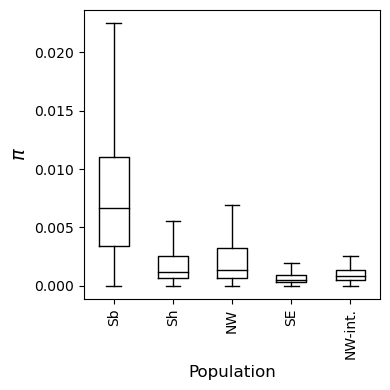

In [37]:
fig, ax = plt.subplots(figsize=(4, 4), facecolor="white")

boxplot = plt.boxplot([sb_pis, sh_pis, nw_pis, se_pis, wo_int_pis],
                      showfliers=False, 
                      notch=False,
                      labels=["Sb", "Sh", "NW", "SE", "NW-int." ],
                      medianprops=dict(color="black", 
                      lw=1))
    
plt.xticks(rotation=90)
plt.xlabel("Population", fontsize=12)
plt.ylabel("$\pi$", fontsize=14)
plt.tight_layout()
plt.savefig("pi_minus_introgressed_sb.svg")
plt.savefig("pi_minus_introgressed_sb.png", dpi=600)
plt.show()

In [22]:
print(f"Sb {sb_pis.mean()}")
print(f"Sh {sh_pis.mean()}")
print(f"NW {nw_pis.mean()}")
print(f"SE {se_pis.mean()}")
print(f"NW (noint) {wo_int_pis.mean()}")

Sb 0.007534431399622242
Sh 0.002291812372136784
NW 0.0026435430128556848
SE 0.0012940643758072917
NW (noint) 0.0013529341283099678


# Fst

In [42]:
fst, se, vb, vj = allel.average_weir_cockerham_fst(masked_gt, [masked_pop_idxs["sh_nw"], masked_pop_idxs["sh_se"]], 10_000)
np.nanmean(vb)

/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in divide
  a = ((n_bar / n_C) *
/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/allel/stats/fst.py:225: RuntimeWarning: invalid value encountered in multiply
  a = ((n_bar / n_C) *
/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in divide
  p = ac / an[:, np.newaxis, :]
/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/allel/stats/fst.py:700: RuntimeWarning: invalid value encountered in scalar divide
  fst = a_sum / (a_sum + b_sum + c_sum)
/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/allel/stats/fst.py:707: RuntimeWarning: invalid value encountered in divide
  vb = num_bsum / den_bsum
/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/allel/stats/fst.py:711: RuntimeWarning:

0.15421667292859065

In [43]:
fst, se, vb, vj = allel.average_weir_cockerham_fst(masked_gt, [masked_pop_idxs["sh_nw"], masked_pop_idxs["sb"]], 10_000)
np.nanmean(vb)

/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0.7875559640393861

In [44]:
fst, se, vb, vj = allel.average_weir_cockerham_fst(masked_gt, [masked_pop_idxs["sh_se"], masked_pop_idxs["sb"]], 10_000)
np.nanmean(vb)

0.7791657981160958

# PCA

In [6]:
!conda run -n bcftools bcftools query -l autosomes_unrelated_minus_introgressed_sb.vcf | wc -l

167


In [7]:
%%bash 

conda run -n vcftools --live-stream vcftools \
    --vcf autosomes_unrelated_minus_introgressed_sb.vcf \
    --missing-indv \
    --stdout \
    >missing_per_indv.tbl


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf autosomes_unrelated_minus_introgressed_sb.vcf
	--missing-indv
	--stdout

After filtering, kept 166 out of 166 Individuals
Outputting Individual Missingness
After filtering, kept 28590241 out of a possible 28590241 Sites
Run Time = 407.00 seconds


In [8]:
%%bash 

conda run -n vcftools --live-stream vcftools \
    --vcf autosomes_unrelated_minus_introgressed_sb.vcf \
    --max-missing 0.5 \
    --maf 0.05 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >pca_prep.vcf



VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf autosomes_unrelated_minus_introgressed_sb.vcf
	--recode-INFO-all
	--maf 0.05
	--max-missing 0.5
	--recode
	--stdout

After filtering, kept 166 out of 166 Individuals
Outputting VCF file...
After filtering, kept 5478020 out of a possible 28590241 Sites
Run Time = 1251.00 seconds


In [10]:
%%bash

#ld filtering
conda run -n popstructure --cwd . --live-stream\
    plink \
        --vcf pca_prep.vcf \
        --allow-extra-chr \
        --double-id \
        --indep-pairwise 25 5 0.20 \
        --vcf-half-call m \
        --out ld

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ld.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 25 5 0.20
  --out ld
  --vcf pca_prep.vcf
  --vcf-half-call m

1031287 MB RAM detected; reserving 515643 MB for main workspace.


Task exception was never retrieved
future: <Task finished name='Task-22' coro=<ScriptMagics.shebang.<locals>._handle_stream() done, defined at /master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/IPython/core/magics/script.py:211> exception=ValueError('Separator is not found, and chunk exceed the limit')>
Traceback (most recent call last):
  File "/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/asyncio/streams.py", line 540, in readline
    line = await self.readuntil(sep)
  File "/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/asyncio/streams.py", line 618, in readuntil
    raise exceptions.LimitOverrunError(
asyncio.exceptions.LimitOverrunError: Separator is not found, and chunk exceed the limit

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/IPython/core/magics/script.py", line 213, in _handle_stream
    line = (a

In [11]:
%%bash

conda run -n popstructure --cwd . --live-stream\
    vcftools \
        --vcf pca_prep.vcf \
        --exclude ld.prune.out \
        --recode \
        --recode-INFO-all \
        --stdout \
        >pca.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf pca_prep.vcf
	--recode-INFO-all
	--recode
	--exclude ld.prune.out
	--stdout

After filtering, kept 166 out of 166 Individuals
Outputting VCF file...
After filtering, kept 337148 out of a possible 5478020 Sites
Run Time = 62.00 seconds


Calculate PCA

In [ ]:
%%bash
conda run -n popstructure --cwd . --live-stream\
    plink \
        --vcf pca.vcf \
        --pca \
        --double-id \
        --allow-extra-chr \
        --out pca

In [16]:
#get eigen values and sample labels
pca_df=pd.read_csv("pca.eigenvec", sep=" ", header=None)
pca_df.columns=["sample_name", "x"] + list(range(1, 21))
pca_df=pca_df.drop("x", axis=1)

# #now add sample info (including location data)
info_df=pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir), sep=",") 

#merge the dataframes
pca_df=pca_df.merge(info_df, how='left', on='sample_name')

#fix the country which contains some float NaNs
pca_df["country"] = pca_df["country"].astype(str)

countries = sorted(pca_df["country"].unique().astype(str))

In [17]:
# pca_df.to_csv("pca_df.csv", index=False, sep=",", header=False, mode='w', na_rep='NaN')



pca_df


,sample_name,1,2,3,4,5,6,7,8,9,...,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon
0,Sb_NG_au_1.2,-0.185229,-0.000372,-0.000431,0.001806,0.019520,0.079794,-0.003038,-0.011938,0.015402,...,SRR11861482,s_bovis,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139
1,Sb_NG_au_2.10,-0.185041,-0.000454,-0.000345,0.003499,0.019502,0.078972,-0.002192,-0.011441,0.014280,...,SRR11861474,s_bovis,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139
2,Sb_NG_au_2.13,-0.185365,-0.000349,-0.000346,0.001886,0.020649,0.082278,-0.002623,-0.011724,0.014815,...,SRR11861472,s_bovis,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139
3,Sb_NG_au_2.5,-0.185430,-0.000373,-0.000465,0.000187,0.021327,0.083243,-0.003524,-0.009788,0.013292,...,SRR11861479,s_bovis,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139
4,Sb_NG_au_2.6,-0.185013,-0.000035,-0.000877,0.003106,0.019783,0.079156,-0.003085,-0.011651,0.016118,...,SRR11861478,s_bovis,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,ssp_niger_libore_166,0.034574,-0.079796,-0.028261,-0.072292,0.006933,-0.018986,-0.112085,-0.029689,0.061605,...,SRR11907495,s_sp,niger,na,snail,unk,scan_africa,genome,13.388050,2.199130
162,ssp_niger_libore_167,0.033600,-0.073423,-0.014435,-0.055456,0.020195,-0.002459,-0.051889,-0.001565,-0.022464,...,SRR11907494,s_sp,niger,na,snail,unk,scan_africa,genome,13.390080,2.197110
163,ssp_niger_libore_168,0.035971,-0.075736,-0.024977,-0.054043,0.003623,0.002044,-0.049592,0.014597,0.019672,...,SRR11907493,s_sp,niger,na,snail,unk,scan_africa,genome,13.390080,2.197110
164,ssp_niger_libore_169,0.035004,-0.076232,-0.022375,-0.064104,0.021975,-0.002387,-0.029919,0.007102,-0.006298,...,SRR11907492,s_sp,niger,na,snail,unk,scan_africa,genome,13.404170,2.188020


In [18]:
pca_df = pca_df.loc[pca_df["presumed_species"].isin(["s_haematobium", "s_sp", "s_bovis"])]

In [19]:
col_df=pd.read_csv(f"{proj_dir}/data/country_colors.csv", sep=",", header=0)
colors = col_df.set_index('country')['color'].to_dict()
colors


{'angola': '#FF0000',
 'swaziland': '#FF1C00',
 'ethiopia': '#FF3800',
 'kenya': '#FF5500',
 'madagascar': '#FF7100',
 'namibia': '#FF8D00',
 'tanzania': '#FFAA00',
 'uganda': '#FFC600',
 'zambia': '#FFE200',
 'zanzibar': '#FFFF00',
 'cameroon': '#0000FF',
 'cote_d_ivoire': '#0019E5',
 'egypt': '#0033CC',
 'gambia': '#004CB2',
 'guineabissau': '#006699',
 'liberia': '#007F7F',
 'mali': '#009965',
 'niger': '#00B24C',
 'nigeria': '#00CC32',
 'senegal': '#00E519',
 'sudan': '#00FF00',
 'na': '#808080'}

In [20]:
markers = { 's_haematobium'  : "o", 
            's_sp'           : "v",
            's_bovis'        : "X",
            's_intercalatum' : "*", 
            's_guineensis'   : "P",
            's_margrebowiei' : "D", 
            's_matthei'      : "s",}

pca_markers= { 's_haematobium'  : "o", 
               's_bovis'        : "X" }


In [21]:
pca_w_intro_df = pd.read_csv("../pca/pca_df.csv")
pca_w_intro_df

,sample_name,1,2,3,4,5,6,7,8,9,...,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species,kmeans_label
0,Sb_NG_au_1.2,-0.173881,0.026648,0.002356,0.003491,0.040333,0.056209,0.034671,-0.018987,0.006714,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
1,Sb_NG_au_2.10,-0.173042,0.026219,0.002305,0.004889,0.041296,0.059342,0.034267,-0.018533,0.003969,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
2,Sb_NG_au_2.13,-0.173645,0.026263,0.002368,0.000767,0.042174,0.060543,0.032764,-0.020686,0.002916,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
3,Sb_NG_au_2.5,-0.172982,0.026137,0.003690,-0.002314,0.042092,0.059532,0.033454,-0.014835,0.000759,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
4,Sb_NG_au_2.6,-0.172250,0.026551,0.002041,0.004355,0.042407,0.059827,0.033576,-0.020790,0.009542,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,ssp_niger_libore_167,0.023576,-0.078099,-0.011150,-0.061000,0.017043,-0.045486,0.040388,-0.017674,0.024366,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
167,ssp_niger_libore_168,0.022321,-0.076938,-0.018901,-0.060000,0.006243,-0.004137,0.029055,-0.042276,0.080228,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
168,ssp_niger_libore_169,0.023969,-0.073719,-0.019718,-0.050199,0.016409,-0.015895,0.038597,-0.020768,0.037634,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw
169,ssp_niger_libore_173,0.026690,-0.083394,-0.003446,-0.070261,-0.010403,-0.085303,0.096133,-0.115088,0.082561,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw


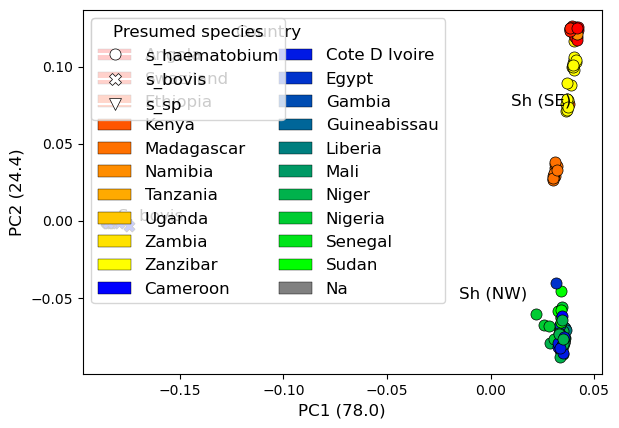

In [23]:
cm = 1 / 2.54

# plot the results
# fig, ax = plt.subplots()
figure(figsize=(17 * cm, 12 * cm))

# figure(figsize=(6,6))
markers = {
    "s_haematobium": "o",
    "s_sp": "v",
    "s_bovis": "X",
    "s_intercalatum": "*",
    "s_guineensis": "P",
    "s_margrebowiei": "D",
    "s_matthei": "s",
}

pca_markers = {"s_haematobium": "o", "s_bovis": "X", "s_sp": "v"}

pca_df = pca_df.sample(frac=1).reset_index(drop=True)
for index, row in pca_df.iterrows():
    if row["presumed_species"] in ["s_haematobium", "s_bovis", "s_sp"]:
        x = row[1]
        y = row[2]

        presumed_species = pca_w_intro_df.loc[pca_w_intro_df["sample_name"] == row["sample_name"], "pca_species"].values[0]
        marker = pca_markers[presumed_species]
        color = colors[row["country"]]

        plt.scatter(
            x, y, marker=marker, color=color, edgecolor="black", linewidths=0.5, s=64
        )


# set x label (eigen 1)
eigen_vals = [line.strip() for line in open(f"{results_dir}/pca/pca.eigenval", "r")]

pc1 = eigen_vals[0]
plt.xlabel(f"PC1 ({float(pc1):.1f})", fontsize=12)

# set x label (eigen 2)
pc2 = eigen_vals[1]
plt.ylabel(f"PC2 ({float(pc2):.1f})", fontsize=12)


# make legend for countries
country_patches = []
for country in colors.keys():
    country_patch = mpatches.Patch(
        facecolor=colors[country],
        edgecolor="black",
        label=country.title().replace("_", " "),
        linewidth=0.3,
    )
    country_patches.append(country_patch)


prop = {"size": 8}
# plt.legend(title="Presumed species", handles=[ssp_marker, ssh_marker, ssb_marker], bbox_to_anchor=(1.05, 0.3))
# plt.legend(title="Presumed species", handles=[ssp_marker, ssh_marker, ssb_marker, sg_marker, si_marker, smar_marker, smat_marker], loc='lower right', prop={'size': 8}, edgecolor="black", fancybox=False, shadow=True)


# add kmeans group annotation
plt.annotate("Sh (SE)", xy=(0.010, 0.075), fontsize=12)
plt.annotate("Sh (NW)", xy=(-0.015, -0.05), fontsize=12)
plt.annotate("S. bovis", xy=(-0.18, 0.00), fontsize=12)
# plt.annotate("Outgroups", xy=( -0.18,   0.075), fontsize=12)


# make legend for countries
country_legend = plt.legend(
    title="Country",
    handles=[
        mpatches.Patch(
            facecolor=colors[country],
            edgecolor="black",
            label=country.title().replace("_", " "),
            linewidth=0.3,
        )
        for country in colors.keys()
    ],
    scatterpoints=1,
    fontsize=12,
    title_fontsize=12,
    #bbox_to_anchor=(0.0, -0.2),
    loc="upper left",
    ncol=2,
)

# Create legend handles for species
species_handles = [
    mlines.Line2D(
        [],
        [],
        color="white",
        markeredgecolor="black",
        markerfacecolor="white",
        marker=marker,
        markersize=8,
        markeredgewidth=0.5,
        label=species,
    )
    for species, marker in pca_markers.items()
]

# make legend for species
species_legend = plt.legend(
    title="Presumed species",
    handles=species_handles,
    scatterpoints=1,
    title_fontsize=12,
    fontsize=12,
    #bbox_to_anchor=(0.625, -0.2),
    loc="upper left",
    ncol=1,
)

plt.gca().add_artist(country_legend)
# plt.tight_layout(pad=1)

# save
plt.savefig("pca_minus_introgressed.png", bbox_inches="tight")
plt.savefig("pca_minus_introgressed.svg", bbox_inches="tight")

plt.show()
# display
plt.close()
